In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)


with open('YALE_Shortness_of_Breath.npy', 'rb') as f:
    X_train = np.load(f)
    y_train = np.load(f).reshape(-1)
    X_test = np.load(f)
    y_test = np.load(f).reshape(-1)

classes = ['0', '1']
classes_name = ['Discharged', 'Admitted']

X_all = np.concatenate((X_train,X_test))
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))

n = X_train.shape[0]
    
print(X_train.shape, y_train.shape, X_train.dtype)
print(X_test.shape, y_test.shape, X_test.dtype)
print(X_all.shape, y_all.shape, X_all.dtype)

y_labels = np.concatenate((y_train,y_test))
print(np.sum(y_labels==0), np.sum(y_labels==1))

DPI = 400

%matplotlib notebook

%load_ext autoreload
%autoreload 2

(19721, 1003) (19721,) float64
(4931, 1003) (4931,) float64
(24652, 1003) (24652,) float64
8861 15791


In [2]:
import numba
from numba import prange

@numba.jit(nopython=True, parallel=True)
def get_first_order_graph(X,n_neighbors):
    
    N = X.shape[0]
    
    dist = np.zeros((N, N), dtype=np.float32)
    #euclidean_distances(X_train, squared = False)

    sort_idx = np.zeros((N,n_neighbors), dtype=np.int32)
    
    for i in range(N):
        if (i+1)%10000 == 0:
            print('Completed ', i+1, ' of ', N)
        
        for j in prange(i+1,N):
            dist[i,j] = np.sum( (X[i]-X[j])**2 )
            dist[j,i] = dist[i,j]
        
        sort_idx[i,:] = np.argsort(dist[i,:])[1:n_neighbors+1]
    
    return sort_idx, dist

@numba.jit(nopython=True, parallel=True)
def my_trustworthiness(Y,sort_idx,K):
    N = Y.shape[0]

    val = 0.0
    for i in prange(N):
        dist = np.sum((Y - Y[i,:])**2,axis=1)
        
        #print(dist.shape)
        
        sort_idy = np.argsort(dist)[1:]
        for j in prange(K):
            r_0 = np.argwhere(sort_idy[j]==sort_idx[i,:])
            #print(i, r_0, sort_idx[i,j])
            #print(sort_idy)
            r = r_0[0,0] 
            #print(i,r)
            #print(sort_idx[i,j])
            #print(sort_idy)
            r_v = r - K + 1
            if r_v>0:
                val += r_v
        #print(val)
    #print(val)
    val = val * 2.0 / ( N*K * (2*N - 3*K - 1.0))
    
    #print(val)
    
    return 1 - val



In [3]:
def fig_plot(X,y,filename):
    plt.figure(figsize=[6,5])
    plt.scatter(X[:,0], X[:,1], c=y, s=0.1, cmap='Spectral')
    
    plt.xticks([],[])
    plt.yticks([],[])
    
    plt.savefig('Shortness/'+filename, bbox_inches='tight')

    return

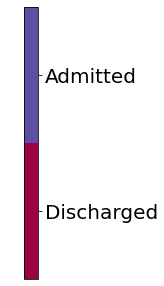

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=[6,5])

fraction = 1  # .05

classes = ['Discharged',
          'Admitted']#,
          #'Discharged (Test)',
          #'Admitted (Test)']

values = np.arange(len(classes))

norm = mpl.colors.Normalize(vmin=values[0], vmax=values[-1])
cbar = ax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='Spectral'),
            boundaries=np.arange(len(classes)+1)-0.5,
            ax=ax, fraction=fraction)
cbar.set_ticks(np.arange(len(classes)))
cbar.set_ticklabels(classes)
cbar.ax.tick_params(labelsize=20)

ax.margins(0,0)

ax.axis('off')
plt.show()

#fig.savefig('Shortness/yale_short_colorbar.png', bbox_inches='tight')

In [5]:
#sort_idx,_ = get_first_order_graph(X_all,n_neighbors=X_all.shape[0]-1)
#sort_idx_tr,_ = get_first_order_graph(X_train,n_neighbors=X_train.shape[0]-1)

sort_idx = []
sort_idx_tr = []

/home/ponir/.local/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


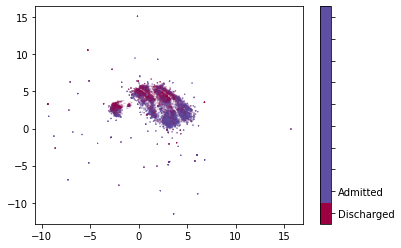

In [6]:
import umap

min_dist = 0.0001

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=min_dist,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap = ump.fit_transform(X_train)
y_umap_test = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

(-2.0, 8.0)

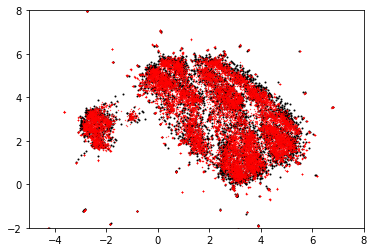

In [7]:
y_all = np.concatenate((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
#plt.figure(figsize=(15,15))

plt.figure()
c1 = 'k'
c2 = 'r'
plt.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=1)
plt.scatter(y_umap[:,0], y_umap[:,1], c=c2, s=0.1)


classes_tr = ['train', 'test']

plt.xlim([-5,8])
plt.ylim([-2,8])

#plt.savefig('Shortness/yale_short_umap_repulsioneffect.png', bbox_inches='tight', dpi=DPI)

In [8]:
def get_indexes(ys, xr, yr):
    
    N1 = len(ys)
    
    idxs = []
    
    for i in range(N1):
        idx_in = True
        if ys[i][0] < xr[0] or ys[i][0] > xr[1]:
            idx_in = False
        if ys[i][1] < yr[0] or ys[i][1] > yr[1]:
            idx_in = False
        
        if idx_in:
            idxs.append(i)
            
    return idxs

idxs_outside = get_indexes(y_umap_test, xr=[3.3, 3.6], yr=[5.0, 5.4])

print(idxs_outside, len(idxs_outside))

idxs_inside = get_indexes(y_umap_test, xr=[3.3, 3.6], yr=[4.52, 4.75])

print(idxs_inside, len(idxs_inside))


idxs_outside2 = get_indexes(y_umap_test, xr=[3.9, 4.3], yr=[0.2, 0.6])

print(idxs_outside2, len(idxs_outside2))

idxs_inside2 = get_indexes(y_umap_test, xr=[3.3, 3.6], yr=[0.8, 1.0])

print(idxs_inside2, len(idxs_inside2))


idxs_outside3 = get_indexes(y_umap_test, xr=[-3.05, -2.93], yr=[2.55, 2.75])

print(idxs_outside3, len(idxs_outside3))

idxs_inside3 = get_indexes(y_umap_test, xr=[-2.8, -2.7], yr=[2.55, 2.75])

print(idxs_inside3, len(idxs_inside3))

[75, 172, 292, 601, 718, 2138, 2148, 2194, 2827, 3027, 3165, 3815, 4147, 4522] 14
[53, 1307, 1577, 2301, 2369, 2740, 2949, 2977, 3493, 3600, 4186, 4492, 4900] 13
[2, 16, 420, 822, 1047, 1580, 1676, 1691, 1736, 2754, 3491, 3705, 4504, 4705] 14
[217, 401, 745, 1836, 2085, 2397, 2897, 2931, 3113, 3274, 3315, 3509, 4850] 13
[318, 1106, 1355, 2258, 3124, 3469, 3716, 3812, 4025, 4178, 4670, 4708] 12
[38, 114, 649, 878, 1291, 1396, 1496, 1886, 2181, 2556, 2601, 2623, 3338, 3395] 14


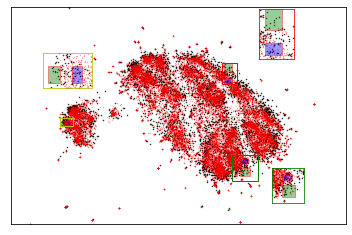

In [9]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

DPI = 400

ar = 6.4/4.8

#plt.figure()
fig, ax = plt.subplots()

def plot_this(ax, alpha_value=0.4):
    c1 = 'k'
    c2 = 'r'
    plt.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=0.2)
    plt.scatter(y_umap[:,0], y_umap[:,1], c=c2, s=0.1, alpha=0.5)

    box1_0 = Rectangle([3.3, 5.0], 3.6-3.3, 5.4-5.0, linewidth=1, edgecolor='r', facecolor='g', alpha=alpha_value)
    ax.add_patch(box1_0)

    box1_i = Rectangle([3.3, 4.52], 3.6-3.3, 4.75-4.52, linewidth=1, edgecolor='r', facecolor='b', alpha=alpha_value)
    ax.add_patch(box1_i)

    box2_0 = Rectangle([3.9, 0.2], 4.3-3.9, 0.6-0.2, linewidth=1, edgecolor='r', facecolor='g', alpha=alpha_value)
    ax.add_patch(box2_0)

    box2_i = Rectangle([3.9, 0.8], 3.6-3.3, 1.0-0.8, linewidth=1, edgecolor='r', facecolor='b', alpha=alpha_value)
    ax.add_patch(box2_i)


    box3_0 = Rectangle([-3.05, 2.55], abs(-3.05--2.93), abs(2.55-2.75), linewidth=1, edgecolor='r', facecolor='g', alpha=alpha_value)
    ax.add_patch(box3_0)


    box3_i = Rectangle([-2.8, 2.55], abs(-2.8--2.7), abs(2.55-2.75), linewidth=1, edgecolor='r', facecolor='b', alpha=alpha_value)
    ax.add_patch(box3_i)

    
plot_this(ax)
plt.xlim([-5,8])
plt.ylim([-2,8])

#plt.text(6.1, 5.55, '$S_1$')
#plt.text(6.48, -1, '$S_2$')
#plt.text(-1.78, 4.25, '$S_3$')

plt.xticks([])
plt.yticks([])

inset_1 = Rectangle([3.2, 4.45], abs(3.8-3.2), abs(5.4-4.45), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(inset_1)

multiplier = 0.18
sub_axes = plt.axes([.7, .7, abs(3.8-3.2)*multiplier/ar, abs(5.4-4.45)*multiplier]) 
plot_this(sub_axes)
plt.xticks([])
plt.yticks([])
sub_axes.spines['bottom'].set_color('red')
sub_axes.spines['top'].set_color('red')
sub_axes.spines['left'].set_color('red')
sub_axes.spines['right'].set_color('red')
#sub_axes.tick_params(axis='x', colors='red')
#sub_axes.tick_params(axis='y', colors='red')
plt.xlim([3.2,3.8])
plt.ylim([4.45,5.4])


inset_2 = Rectangle([-3.1, 2.5], abs(-3.1+2.6), abs(2.5-2.9), linewidth=1, edgecolor='y', facecolor='none')
ax.add_patch(inset_2)
multiplier = 0.3
sub_axes2 = plt.axes([.2, .6, abs(-3.1+2.6)*multiplier/ar, abs(2.5-2.9)*multiplier]) 
plot_this(sub_axes2)
sub_axes2.spines['bottom'].set_color('y')
sub_axes2.spines['top'].set_color('y')
sub_axes2.spines['left'].set_color('y')
sub_axes2.spines['right'].set_color('y')
plt.xticks([])
plt.yticks([])
plt.xlim([-3.1,-2.6])
plt.ylim([2.5,2.9])


inset_3 = Rectangle([3.6, 0.0], abs(3.6-4.6), abs(1.2), linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(inset_3)
multiplier = 0.1
sub_axes3 = plt.axes([.73, 0.2, abs(3.6-4.6)*multiplier/ar, abs(1.2)*multiplier]) 
plot_this(sub_axes3)
sub_axes3.spines['bottom'].set_color('g')
sub_axes3.spines['top'].set_color('g')
sub_axes3.spines['left'].set_color('g')
sub_axes3.spines['right'].set_color('g')
plt.xticks([])
plt.yticks([])
plt.xlim([3.6,4.6])
plt.ylim([0, 1.2])


## plot the zoomed portion
#sub_axes.scatter(y_umap_test[:,0], y_umap_test[:,1], c=c1, s=0.1)

plt.savefig('Shortness/yale_short_rfr_afr_places.png', bbox_inches='tight', dpi=DPI)

In [10]:
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    #print(max(d))
    return weight


def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs


def get_ab(MIN_DIST):

    x = np.linspace(0, 3, 300)
    y = np.exp(- (x-MIN_DIST) * ( (x - MIN_DIST) >=0 ) )

    dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

    p , _ = optimize.curve_fit(dist_low_dim, x, y)

    a = p[0]
    b = p[1] 
    #print("Hyperparameters a = " + str(a) + " and b = " + str(b))

    return a, b


def nearest_neighbors_search(x, x_train, y, y_train, n_neighbors, min_dist):
    
    dist = np.sqrt(np.sum((x_train-x)**2,axis=1))
    sort_idx = np.argsort(dist)
    rho = dist[sort_idx[0]]
    x_dists = dist[sort_idx[:n_neighbors]]
    
    y_diff = y_train[sort_idx[:n_neighbors]]-y
    y_dists = np.sqrt(np.sum(( y_diff )**2,axis=1))
    
    
    #print(dist[:15])
    #print(np.sort(dist)[:15])
    #print(dist[sort_idx[:15]])
    
    sigma, weight = search_sigma(dists = x_dists,rho = rho,k = n_neighbors)
    
    a,b = get_ab(min_dist)
    
    
    ps = weight
    qs = 1 / ( 1 + a * (y_dists) ** b )
    
    #print(ps)
    #print(qs)
    
    pos_loss = np.log(ps/qs+10**-10)
    neg_loss = np.log((1-ps)/(1-qs)+10**-10)
    
    ratio = np.sum(pos_loss/neg_loss)
    
    
    attraction_forces = 2*a*b*y_dists**(b-1.0) / (1 + a * y_dists**b)
    aforces = 0
    af_sum = 0
    
    repulsion_forces = 2 * b / ( y_dists * (1.0 + a * y_dists**b) )
    rforces = 0
    rf_sum = 0
    
    for i in range(len(repulsion_forces)):
        rforces += repulsion_forces[i] * y_diff[i] * (1-ps[i])
        rf_sum += np.sum((repulsion_forces[i] * y_diff[i])**2)
        
        #print(repulsion_forces[i] * y_diff[i], rforces, np.sum((repulsion_forces[i] * y_diff[i])**2), rf_sum)
        #print(forces)
        aforces += attraction_forces[i] * y_diff[i] * ps[i]
        af_sum += np.sum((attraction_forces[i] * y_diff[i])**2)
        
    repulsion_force = np.sqrt(np.sum(rforces**2)) #/len(repulsion_forces)
    attraction_force = np.sqrt(np.sum(aforces**2)) #/len(attraction_forces)
    
    
    #print(ratio,repulsion_force, attraction_force)
    #print(rforces, rf_sum)
    
    return ratio, repulsion_force, attraction_force

ratio, repulsion_force, attraction_force = nearest_neighbors_search(X_test[0,:], X_train, 
                                    y_umap_test[0,:], y_umap, 
                                    n_neighbors=30, min_dist=min_dist)

<h1>n_s=3</h1>

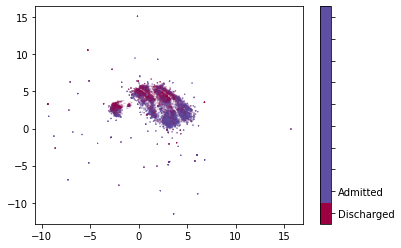

In [11]:
import umap

min_dist = 0.0001

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=min_dist,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap_3 = ump.fit_transform(X_train)
ump.negative_sample_rate = 3
y_umap_test_3 = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap[:,0], y_umap[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<h1>UMAP ns=1</h1>

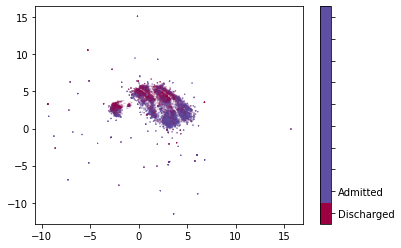

In [12]:
import umap

min_dist = 0.0001

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=min_dist,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

y_umap_1 = ump.fit_transform(X_train)
ump.negative_sample_rate = 1
y_umap_test_1 = ump.transform(X_test)

plt.figure()
plt.scatter(y_umap_1[:,0], y_umap_1[:,1], c=y_train, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<h1>UMAP ALL</h1>

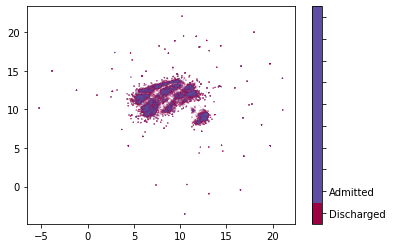

In [13]:
import umap

np.random.seed(100)
ump = umap.UMAP(n_neighbors=30,
        min_dist=0.0001,
        n_components=2,
        random_state=150,
        metric= 'euclidean')

t_umap_all = ump.fit_transform(X_all)
t_umap_all_train = t_umap_all[:X_train.shape[0]]
t_umap_all_test = t_umap_all[X_train.shape[0]:]

plt.figure()
plt.scatter(t_umap_all[:,0], t_umap_all[:,1], c=y_all, s=0.01, cmap='Spectral')

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

<h1>P-UMAP-CEMSE</h1>

In [15]:
from scipy.io import loadmat

d = loadmat('nets_MSE_CE_UMAP/test_data19.mat')
t_cemse = d['Y'].copy()
t_cemse_test = d['Y_test'].copy()
t_cemse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()

<h1>P-UMAP-CE</h1>

In [16]:
from scipy.io import loadmat

d = loadmat('nets_CE/test_data39.mat')
t_ce = d['Y'].copy()
t_ce_test = d['Y_test'].copy()
t_ce_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()


<h1>Analyzing All</h1>

In [17]:
idxs_out_all = np.concatenate((idxs_outside, idxs_outside2, idxs_outside3))
idxs_in_all = np.concatenate((idxs_inside, idxs_inside2, idxs_inside3))

print(len(idxs_out_all), len(idxs_in_all))
print(idxs_out_all)
print(idxs_in_all)

40 40
[  75  172  292  601  718 2138 2148 2194 2827 3027 3165 3815 4147 4522
    2   16  420  822 1047 1580 1676 1691 1736 2754 3491 3705 4504 4705
  318 1106 1355 2258 3124 3469 3716 3812 4025 4178 4670 4708]
[  53 1307 1577 2301 2369 2740 2949 2977 3493 3600 4186 4492 4900  217
  401  745 1836 2085 2397 2897 2931 3113 3274 3315 3509 4850   38  114
  649  878 1291 1396 1496 1886 2181 2556 2601 2623 3338 3395]


Points Outside: 
Points inside
ns=5
AFR:  0.5900396 1.6948014702569556 AFR 2: 0.6948014702569556
RFR:  0.67065066 1.491089263255677 RFR 2: 0.4910892632556769
(40, 2)
[]


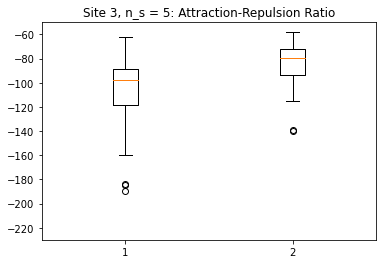

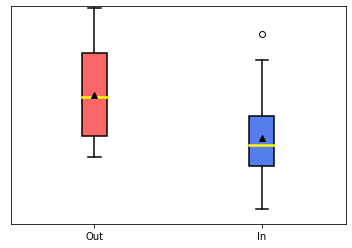

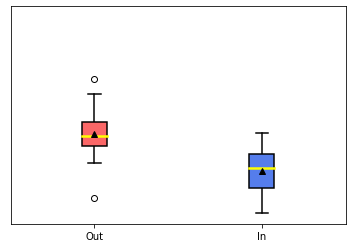

In [18]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    y_umap_test[idxs_out[i],:], y_umap, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    y_umap_test[idxs_in[i],:], y_umap, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

afr_rat = np.sum(af_inside)/np.sum(af_outside)
rfr_rat = np.sum(rf_inside)/np.sum(rf_outside)
print('ns=5')
print('AFR: ', afr_rat, 1/afr_rat, 'AFR 2:', np.abs(1-1/afr_rat))
print('RFR: ', rfr_rat, 1/rfr_rat, 'RFR 2:', np.abs(1-1/rfr_rat))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-230,-50])
plt.title('Site 3, n_s = 5: Attraction-Repulsion Ratio')

rf_ylim = [0,20]

tick_labels = ['Out', 'In']
colors = ['#fb6767', '#557dec']

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(rf_ylim)

plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_rf_UMAP_ns5.png', dpi=DPI, bbox_inches='tight')
#plt.savefig('short_box_plots/bx_short_rf_UMAP_ns5.svg', dpi=DPI, bbox_inches='tight')

af_ylim = [0, 7]

plt.figure()
bp2 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(af_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_af_UMAP_ns5.png', dpi=DPI, bbox_inches='tight')
#plt.savefig('short_box_plots/bx_short_af_UMAP_ns5.', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
ns=3
AFR:  0.712022 1.4044509732208459 AFR 2: 0.4044509732208459
RFR:  0.6814059 1.467554063148886 RFR 2: 0.4675540631488859
(40, 2)
[]


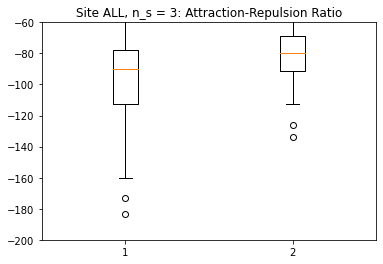

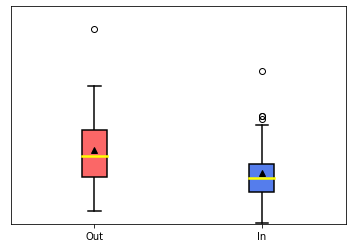

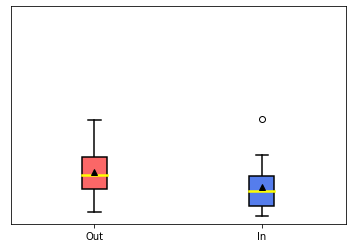

In [19]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    y_umap_test_3[idxs_out[i],:], y_umap_3, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    y_umap_test_3[idxs_in[i],:], y_umap_3, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

afr_rat = np.sum(af_inside)/np.sum(af_outside)
rfr_rat = np.sum(rf_inside)/np.sum(rf_outside)

print('ns=3')
print('AFR: ', afr_rat, 1/afr_rat, 'AFR 2:', np.abs(1-1/afr_rat))
print('RFR: ', rfr_rat, 1/rfr_rat, 'RFR 2:', np.abs(1-1/rfr_rat))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, n_s = 3: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(rf_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_rf_UMAP_ns3.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp2 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(af_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_af_UMAP_ns3.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
ns=1
AFR:  0.776835 1.2872746061210627 AFR 2: 0.2872746061210627
RFR:  0.86161345 1.1606132624490029 RFR 2: 0.16061326244900287
(40, 2)
[]


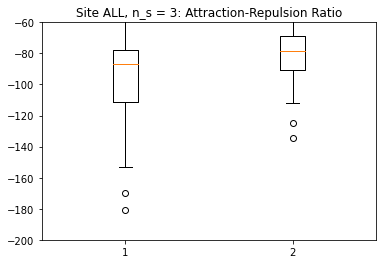

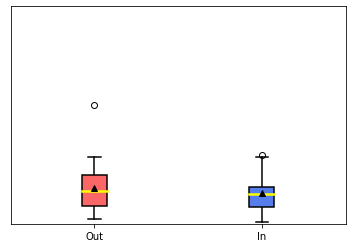

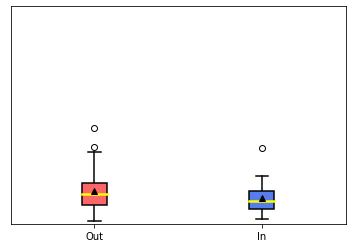

In [20]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    y_umap_test_1[idxs_out[i],:], y_umap_1, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    y_umap_test_1[idxs_in[i],:], y_umap_1, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

afr_rat = np.sum(af_inside)/np.sum(af_outside)
rfr_rat = np.sum(rf_inside)/np.sum(rf_outside)

print('ns=1')
print('AFR: ', afr_rat, 1/afr_rat, 'AFR 2:', np.abs(1-1/afr_rat))
print('RFR: ', rfr_rat, 1/rfr_rat, 'RFR 2:', np.abs(1-1/rfr_rat))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, n_s = 3: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(rf_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_rf_UMAP_ns1.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp2 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(af_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_af_UMAP_ns1.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
UMAP All: 
AFR:  0.7176418 1.3934528906113282 AFR 2: 0.39345289061132815
RFR:  0.89448124 1.1179664294536416 RFR 2: 0.11796642945364155
(40, 2)
[]


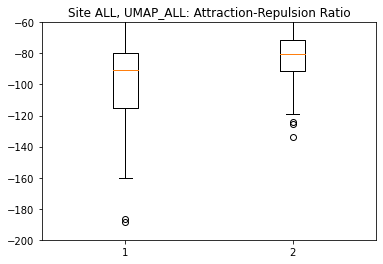

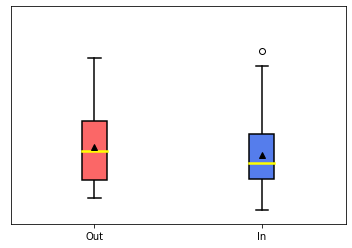

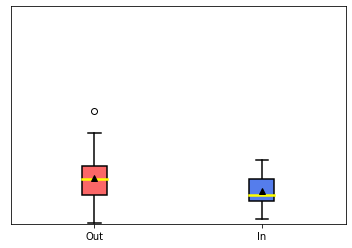

In [21]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    t_umap_all_test[idxs_out[i],:], t_umap_all_train, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    t_umap_all_test[idxs_in[i],:], t_umap_all_train, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

afr_rat = np.sum(af_inside)/np.sum(af_outside)
rfr_rat = np.sum(rf_inside)/np.sum(rf_outside)

print('UMAP All: ')
print('AFR: ', afr_rat, 1/afr_rat, 'AFR 2:', np.abs(1-1/afr_rat))
print('RFR: ', rfr_rat, 1/rfr_rat, 'RFR 2:', np.abs(1-1/rfr_rat))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, UMAP_ALL: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(rf_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_rf_UMAP_all.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp2 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(af_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_af_UMAP_all.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
UMAP CE
AFR:  0.7667606 1.304188055635105 AFR 2: 0.3041880556351051
RFR:  1.0209279 0.9795010931598227 RFR 2: 0.0204989068401773
(40, 2)
[]


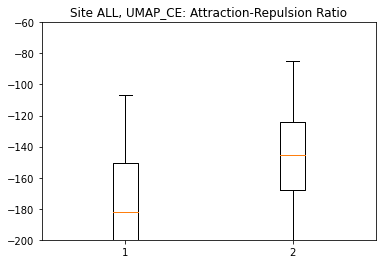

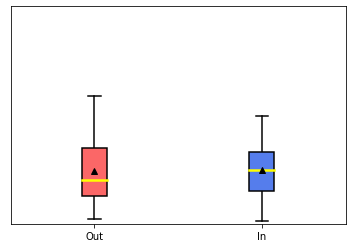

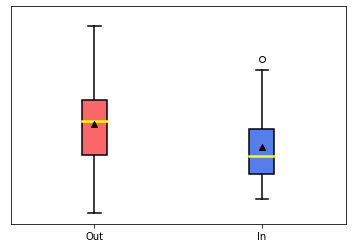

In [22]:
print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    t_ce_test[idxs_out[i],:], t_ce, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    t_ce_test[idxs_in[i],:], t_ce, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

afr_rat = np.sum(af_inside)/np.sum(af_outside)
rfr_rat = np.sum(rf_inside)/np.sum(rf_outside)

print('UMAP CE')
print('AFR: ', afr_rat, 1/afr_rat, 'AFR 2:', np.abs(1-1/afr_rat))
print('RFR: ', rfr_rat, 1/rfr_rat, 'RFR 2:', np.abs(1-1/rfr_rat))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, UMAP_CE: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(rf_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_rf_UMAP_CE.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp2 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim([0,7])
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_af_UMAP_CE.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
UMAP CEMSE
AFR:  0.79410046 1.2592865085742144 AFR 2: 0.2592865085742144
RFR:  0.86404973 1.1573407897395407 RFR 2: 0.1573407897395407
(40, 2)
[]


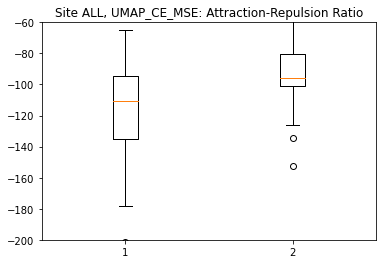

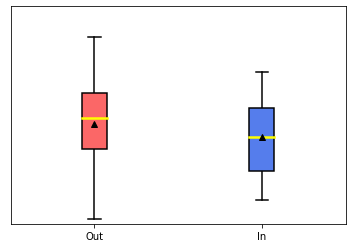

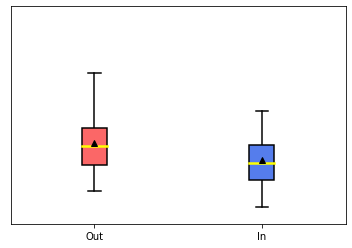

In [24]:
from scipy.io import loadmat

d = loadmat('nets_MSE_CE_UMAP/test_data19.mat')
t_cemse = d['Y'].copy()
t_cemse_test = d['Y_test'].copy()
t_cemse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()

print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    t_cemse_test[idxs_out[i],:], t_cemse, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    t_cemse_test[idxs_in[i],:], t_cemse, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

afr_rat = np.sum(af_inside)/np.sum(af_outside)
rfr_rat = np.sum(rf_inside)/np.sum(rf_outside)

print('UMAP CEMSE')
print('AFR: ', afr_rat, 1/afr_rat, 'AFR 2:', np.abs(1-1/afr_rat))
print('RFR: ', rfr_rat, 1/rfr_rat, 'RFR 2:', np.abs(1-1/rfr_rat))

print(ratios.shape)

print(sort_idx)

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, UMAP_CE_MSE: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(rf_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_rf_UMAP_cemse.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp2 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(af_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_af_UMAP_cemse.png', dpi=DPI, bbox_inches='tight')

Points Outside: 
Points inside
MSE
AFR:  0.884941 1.130018860571464 AFR 2: 0.13001886057146406
RFR:  0.9414127 1.0622334003871274 RFR 2: 0.062233400387127435
(40, 2)
[]


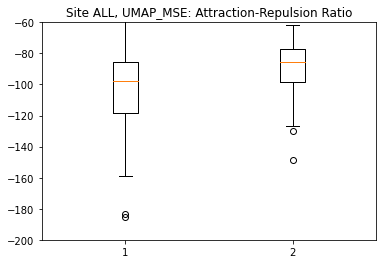

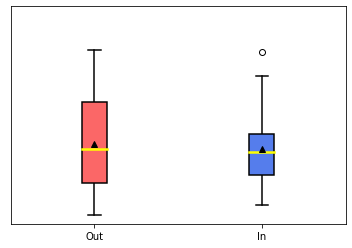

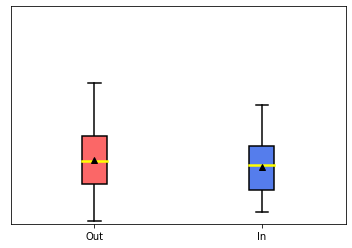

In [25]:
from scipy.io import loadmat

d = loadmat('nets_MSE_UMAP/test_data19.mat')
t_mse = d['Y'].copy()
t_mse_test = d['Y_test'].copy()
t_mse_tr_te = np.concatenate((d['Y'],d['Y_test'])).copy()

print('Points Outside: ')

idxs_out = idxs_out_all
idxs_in = idxs_in_all

ratios_outside = []
rf_outside = []
af_outside = []
for i in range(len(idxs_out)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_out[i],:], X_train, 
                                    t_mse_test[idxs_out[i],:], t_mse, 
                                    n_neighbors=30, min_dist=min_dist)
    
    ratios_outside.append(ratio)
    rf_outside.append(repulsion_forces)
    af_outside.append(attraction_force)

    
print('Points inside')
ratios_inside = []
rf_inside = []
af_inside = []
for i in range(len(idxs_in)):
    ratio, repulsion_forces, attraction_force = nearest_neighbors_search(X_test[idxs_in[i],:], X_train, 
                                    t_mse_test[idxs_in[i],:], t_mse, 
                                    n_neighbors=30, min_dist=min_dist)
    ratios_inside.append(ratio)
    rf_inside.append(repulsion_forces)
    af_inside.append(attraction_force)

ratios = np.array([ratios_outside, ratios_inside]).T
rf_all = np.array([rf_outside, rf_inside]).T
af_all = np.array([af_outside, af_inside]).T

afr_rat = np.sum(af_inside)/np.sum(af_outside)
rfr_rat = np.sum(rf_inside)/np.sum(rf_outside)

print('MSE')
print('AFR: ', afr_rat, 1/afr_rat, 'AFR 2:', np.abs(1-1/afr_rat))
print('RFR: ', rfr_rat, 1/rfr_rat, 'RFR 2:', np.abs(1-1/rfr_rat))

print(ratios.shape)

print(sort_idx)

tick_labels = ['Out', 'In']
colors = ['#fb6767', '#557dec']

plt.figure()
plt.boxplot(ratios)
plt.ylim([-200,-60])
plt.title('Site ALL, UMAP_MSE: Attraction-Repulsion Ratio')

plt.figure()
bp2 = plt.boxplot(rf_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(rf_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Repulsion Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_rf_UMAP_mse.png', dpi=DPI, bbox_inches='tight')

plt.figure()
bp2 = plt.boxplot(af_all,
                  vert=True,  
                  patch_artist=True, 
                  labels=tick_labels,
                  showmeans = True,
                  meanprops = dict(markeredgecolor='k',markerfacecolor='k'),
                  whiskerprops = dict(linewidth=1.5),
                  capprops = dict(linewidth=1.5),
                  boxprops = dict(linewidth=1.5),
                  medianprops=dict(color='yellow', linewidth=2.5))
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
plt.ylim(af_ylim)
plt.yticks([])
#plt.title('Site ALL, n_s = 3: Attraction Forces')
plt.xticks([1, 2], ['Out', 'In'])
plt.savefig('short_box_plots/bx_short_af_UMAP_mse.png', dpi=DPI, bbox_inches='tight')